In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torchvision.models import resnet152, ResNet152_Weights
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
import time
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             ConfusionMatrixDisplay, classification_report)
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import os
from collections import Counter
import matplotlib.pyplot as plt
import copy # Needed for deep copying states if required

print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")

PyTorch Version: 2.6.0+cu124
Torchvision Version: 0.21.0+cu124


In [ ]:
DATA_DIR = "/kaggle/input/eye-diseases-classification/dataset"
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0005
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_SAVE_PATH = "best_multiclass_eye_disease_vitb16_model.pth"
NUM_WORKERS = 2
RANDOM_SEED = 42

# Set seed for reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Using device: {DEVICE}")
print(f"Number of workers for DataLoader: {NUM_WORKERS}")
print(f"Data Directory: {DATA_DIR}")
print(f"Model save path: {MODEL_SAVE_PATH}")

Using device: cuda
Number of workers for DataLoader: 2
Data Directory: /kaggle/input/eye-diseases-classification/dataset
Model save path: best_multiclass_eye_disease_vitb16_model.pth


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset structure initially to get labels, classes, and perform split
try:
    initial_dataset = datasets.ImageFolder(root=DATA_DIR, transform=val_test_transform)
    if len(initial_dataset) == 0:
        raise ValueError("Dataset is empty or not found. Check DATA_DIR and dataset structure.")

    labels = np.array([label for _, label in initial_dataset.samples])
    class_names = initial_dataset.classes
    NUM_CLASSES = len(class_names)

    print(f"Dataset classes found: {class_names} ({NUM_CLASSES} classes)")
    print(f"Total images found: {len(initial_dataset)}")
    print(f"Initial Class distribution: {Counter(labels)}")
    if NUM_CLASSES <= 1:
         print("Warning: Expected multiple classes, but found only {NUM_CLASSES}. Check dataset structure.")


except (FileNotFoundError, ValueError, Exception) as e:
    print(f"Error loading dataset: {e}")
    print("Please ensure the DATA_DIR is correct and the dataset follows the ImageFolder structure (e.g., DATA_DIR/class1/..., DATA_DIR/class2/...).")
    raise e

# Train/Validation/Test split (e.g., 70/15/15 or 60/20/20) using 70/15/15
splitter_train_valtest = StratifiedShuffleSplit(n_splits=1,
                                                test_size=0.3,
                                                random_state=RANDOM_SEED) # 70% train, 30% temp
train_idx, temp_idx = next(splitter_train_valtest.split(np.zeros(len(labels)), labels))

temp_labels = labels[temp_idx]
# Split the 30% temp into 15% validation and 15% test (0.5 ratio of the temp set)
splitter_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=RANDOM_SEED)
val_idx_rel, test_idx_rel = next(splitter_val_test.split(np.zeros(len(temp_labels)), temp_labels))

val_idx = temp_idx[val_idx_rel]
test_idx = temp_idx[test_idx_rel]

# Create datasets with the *correct* transforms assigned to the underlying ImageFolder instances
train_dataset_instance = datasets.ImageFolder(root=DATA_DIR, transform=train_transform)
val_test_dataset_instance = datasets.ImageFolder(root=DATA_DIR, transform=val_test_transform)

train_data = Subset(train_dataset_instance, train_idx)
val_data = Subset(val_test_dataset_instance, val_idx)
test_data = Subset(val_test_dataset_instance, test_idx)


print(f"\nData Split:")
print(f"Train samples: {len(train_data)}, Class distribution: {Counter(labels[train_idx])}")
print(f"Validation samples: {len(val_data)}, Class distribution: {Counter(labels[val_idx])}")
print(f"Test samples: {len(test_data)}, Class distribution: {Counter(labels[test_idx])}")

# Dataloaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=False)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"\nDataloaders created with Batch Size: {BATCH_SIZE}")

Dataset classes found: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal'] (4 classes)
Total images found: 4217
Initial Class distribution: Counter({np.int64(1): 1098, np.int64(3): 1074, np.int64(0): 1038, np.int64(2): 1007})

Data Split:
Train samples: 2951, Class distribution: Counter({np.int64(1): 768, np.int64(3): 752, np.int64(0): 726, np.int64(2): 705})
Validation samples: 633, Class distribution: Counter({np.int64(1): 165, np.int64(3): 161, np.int64(0): 156, np.int64(2): 151})
Test samples: 633, Class distribution: Counter({np.int64(1): 165, np.int64(3): 161, np.int64(0): 156, np.int64(2): 151})

Dataloaders created with Batch Size: 32


In [ ]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

# Load pretrained ViT model
weights = ViT_B_16_Weights.DEFAULT
model = vit_b_16(weights=weights)

print("Freezing all model parameters initially...")
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last encoder layer and the classification head
print("Unfreezing last encoder layer and classifier head for fine-tuning...")
for param in model.encoder.layers[-1].parameters():
    param.requires_grad = True
for param in model.heads.head.parameters():
    param.requires_grad = True

# Replace the final classification head
num_ftrs = model.heads.head.in_features
print(f"Original ViT head input features: {num_ftrs}")
model.heads.head = nn.Linear(num_ftrs, NUM_CLASSES)
print(f"Replaced head for {NUM_CLASSES}-class classification.")

model = model.to(DEVICE)

# Count trainable and total parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total model parameters: {total_params:,}")
print(f"Trainable model parameters: {trainable_params:,} ({100 * trainable_params / total_params:.2f}%)")


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 187MB/s]


Freezing all model parameters initially...
Unfreezing last encoder layer and classifier head for fine-tuning...
Original ViT head input features: 768
Replaced head for 4-class classification.
Total model parameters: 85,801,732
Trainable model parameters: 7,090,948 (8.26%)


In [ ]:
print("\n--- Setting up Loss, Optimizer, Scheduler ---")
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
print(f"Loss function: {criterion}")

optimizer = optim.Adam(filter(lambda p: p.requires_grad,
                              model.parameters()),
                       lr=LEARNING_RATE,
                       weight_decay=2e-4)
print(f"Optimizer: Adam with LR={LEARNING_RATE}, Weight Decay=1e-4")

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 mode='min',
                                                 factor=0.2,
                                                 patience=4)
print(f"Scheduler: ReduceLROnPlateau (mode='min', patience=4, factor=0.2)")


--- Setting up Loss, Optimizer, Scheduler ---
Loss function: CrossEntropyLoss()
Optimizer: Adam with LR=0.0005, Weight Decay=1e-4
Scheduler: ReduceLROnPlateau (mode='min', patience=4, factor=0.2)


In [ ]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for i, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images) # Raw logits
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        with torch.no_grad():
            _, predicted_labels = torch.max(outputs, 1)
            correct_predictions += (predicted_labels == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc


print("Done")

Done


In [ ]:
# Re-create optimizer and scheduler
optimizer = optim.Adam(filter(lambda p: p.requires_grad,
                              model.parameters()),
                       lr=LEARNING_RATE,
                       weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 mode='min',
                                                 factor=0.2,
                                                 patience=4)

# Define history
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'val_f1_macro': [],
    'test_loss': [], 'test_acc': [], 'test_f1_macro': []
}
best_val_loss = float('inf')
best_val_acc = 0.0

start_train_time = time.time()

for epoch in range(EPOCHS):
    epoch_start_time = time.time()

    # --- Train ---
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # --- Validate ---
    val_metrics = evaluate_model(model, val_loader, criterion, DEVICE, class_names)
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    val_f1_macro = val_metrics["f1_macro"]
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1_macro'].append(val_f1_macro) # Store F1 macro

    # --- Test ---
    test_metrics = evaluate_model(model, test_loader, criterion, DEVICE, class_names)
    test_loss = test_metrics["loss"]
    test_acc = test_metrics["accuracy"]
    test_f1_macro = test_metrics["f1_macro"]
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    history['test_f1_macro'].append(test_f1_macro)

    # --- Scheduler Step ---
    scheduler.step(val_loss)

    # --- Print Epoch Results ---
    epoch_time = time.time() - epoch_start_time
    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Time: {epoch_time:.2f}s | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f} (F1m: {val_f1_macro:.4f}) | "
          f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f} (F1m: {test_f1_macro:.4f})")

    # --- Save Best Model Checkpoint (Dictionary based on Validation Loss and Accuracy) ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"   -> Val Loss improved to {best_val_loss:.4f}. Saving Model Checkpoint...")
        checkpoint = {
            'epoch': epoch + 1,
            'num_classes': NUM_CLASSES,
            'class_names': class_names,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_metrics': val_metrics
        }
        try:
            torch.save(checkpoint, MODEL_SAVE_PATH)
        except Exception as e:
            print(f"   *Error saving checkpoint*: {e}")

    current_val_acc = val_metrics["accuracy"]
    if current_val_acc > best_val_acc:
       best_val_acc = current_val_acc
       print(f"   -> Val Accuracy improved to {best_val_acc:.4f}. Saving Accuracy Checkpoint...")
       try:
           torch.save(checkpoint, "best_acc_checkpoint.pth")
       except Exception as e:
           print(f"   *Error saving accuracy checkpoint*: {e}")


total_train_time = time.time() - start_train_time
print(f"Total Training Time: {total_train_time // 60:.0f}m {total_train_time % 60:.0f}s")
print(f"Best Validation Loss achieved: {best_val_loss:.4f}")
print(f"Best model checkpoint saved to: {MODEL_SAVE_PATH}")

Epoch 1/20 | Time: 67.65s | LR: 0.000500 | Train Loss: 0.8634, Acc: 0.7184 | Val Loss: 0.6520, Acc: 0.8657 (F1m: 0.8642) | Test Loss: 0.6773, Acc: 0.8357 (F1m: 0.8331)
   -> Val Loss improved to 0.6520. Saving Model Checkpoint...
   -> Val Accuracy improved to 0.8657. Saving Accuracy Checkpoint...
Epoch 2/20 | Time: 60.38s | LR: 0.000500 | Train Loss: 0.6828, Acc: 0.8279 | Val Loss: 0.6178, Acc: 0.8594 (F1m: 0.8490) | Test Loss: 0.6721, Acc: 0.8341 (F1m: 0.8217)
   -> Val Loss improved to 0.6178. Saving Model Checkpoint...
Epoch 3/20 | Time: 61.30s | LR: 0.000500 | Train Loss: 0.6194, Acc: 0.8631 | Val Loss: 0.5472, Acc: 0.9068 (F1m: 0.9053) | Test Loss: 0.5860, Acc: 0.8736 (F1m: 0.8720)
   -> Val Loss improved to 0.5472. Saving Model Checkpoint...
   -> Val Accuracy improved to 0.9068. Saving Accuracy Checkpoint...
Epoch 4/20 | Time: 62.06s | LR: 0.000500 | Train Loss: 0.5910, Acc: 0.8743 | Val Loss: 0.5625, Acc: 0.8910 (F1m: 0.8867) | Test Loss: 0.5964, Acc: 0.8784 (F1m: 0.8723)
Epoc

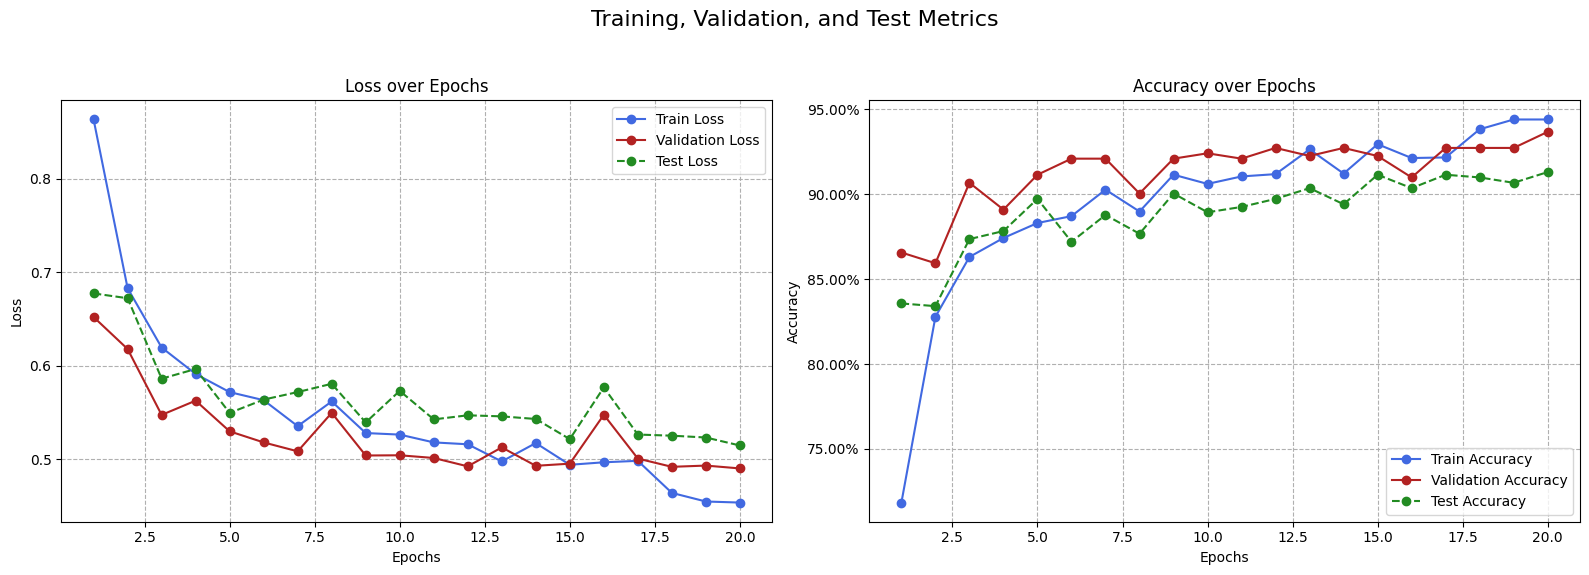

In [ ]:
plot_history(history)


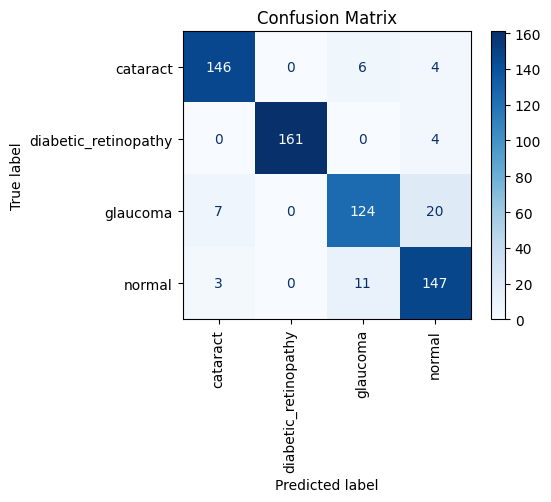

In [ ]:
plot_confusion_matrix(test_metrics['confusion_matrix'],
                      class_names=['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal'],
                      title='Confusion Matrix')
